In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords, wordnet

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score

# import pickle
# import pickletools

In [2]:
most_recent_extract = '2023-06-11 16:25'
df = pd.read_csv(f'data/reddit_posts_raw_{most_recent_extract}.csv')

In [3]:
df.shape

(1971, 6)

In [4]:
df.head(1)

,subreddit,id,created_utc,title,selftext,top_comment_text
0,dating,1471ube,2023-06-11 18:49:33,Am I Clueless?,So there is this girl I’ve known my whole life...,NaN


### Self-text only

In [5]:
X = pd.Series(df['selftext'])
y = df['subreddit'].map({'dating': 0,
                    'datingoverthirty':1})

### Self Text and Top Comment - Alternative Path

In [6]:
# df['self_text_and_comment'] = df['self_text'].astype(str) + df['top_comment_text'].astype(str)
# X = pd.Series(df['self_text_and_comment'])
# y = df['subreddit'].map({'dating': 0,
#                    'datingoverthirty':1})

### Train-Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)
# X_train.to_pickle('./pickled_models/X_train.pkl')
# X_test.to_pickle('./pickled_models/X_test.pkl')
# y_train.to_pickle('./pickled_models/y_train.pkl')
# y_test.to_pickle('./pickled_models/y_test.pkl')

# X_train = pd.read_pickle('./pickled_models/X_train.pkl')
# X_test = pd.read_pickle('./pickled_models/X_test.pkl')
# y_train = pd.read_pickle('./pickled_models/y_train.pkl')
# y_test = pd.read_pickle('./pickled_models/y_test.pkl')

#### Baseline

> The majority class holds 50.63% of responses.  This is the baseline score to beat.

> Even class distribution makes a 75/25 train test split possible.

In [8]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
dummy_preds = dummy.predict(y_test)
dummy_accuracy = accuracy_score(y_test, dummy_preds)
dummy_accuracy

0.5091277890466531

## Baseline Investigation with Standard Vectorizers

#### CountVectorizer

In [9]:
cvec0 = CountVectorizer() #standard CountVectorizer
cvec0.fit(X_train)
# pickle.dump(cvec0, open('./pickled_models/cvec0_baseline', 'wb'))

CountVectorizer()

> See Model Investigaion for Investigations

#### Tf-Idf Vectorizer

In [10]:
tvec0 = TfidfVectorizer()
tvec0.fit(X_train)
# pickle.dump(tvec0, open('./pickled_models/tvec0_baseline', 'wb'))

TfidfVectorizer()

> See Model Investigation for Investigations

## Modeling

#### Stemming and Lematizing

In [11]:
p_stemmer = PorterStemmer()
def stem_post(post):
    split_post = post.split(' ')
    return ' '.join([p_stemmer.stem(word) for word in split_post])
#cite 6/9 Breakfast Hour

In [12]:
# pickle.dump(stem_post, open('./pickled_models/function_stem_post.pkl', 'wb'))

In [13]:
lemmatizer = WordNetLemmatizer()
# cite: Lesson 504 NLP 1 - Modified to handle complete words.
def lemmatize_post(post):
    mapper = { 
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }
    post_split = post.split(' ')
    post_tokens = [(token, tag) for token, tag in nltk.pos_tag(post_split)]
    post_lem = []
    for token in post_tokens:
        pos = mapper.get(token[1][0])
        # post_lem.append((token[0],pos) if pos != None else (token[0]))
        post_lem.append(lemmatizer.lemmatize(token[0], pos) if pos != None else token[0])
    return ' '.join(post_lem).lower()

In [14]:
# pickle.dump(lemmatize_post, open('./pickled_models/function_lemmatize_post', 'wb'))

## RS-0
RandomSearchCV over Multiple Model Types with Tfidf Vectorization

In [15]:
# Evaluating multiple classifiers in the same RandomSearchCV, trying different combinations of Tfidf / CountVectorizer and LogisticRegression() / MultinomialNB
# Inspiration: Wrapper Class (https://stackoverflow.com/questions/50285973/pipeline-multiple-classifiers).  Content: DSI Lesson 507 on OOP (https://git.generalassemb.ly/bobadams1/507-lesson-object-oriented-programming)
'''
Notes from Inspiration above (no copy-paste):
1. Need BaseEstimator() as the base class for all sklearn estimators - as a stand in for the estimator being selected
2. The class only really needs to to have self and the estimator as objects in the class.
3. The methods you would normally call for the estimator should be defined as functions within the model (don't forget to pass self every time!)
'''
from sklearn.base import BaseEstimator

class Multi_Classifier(BaseEstimator):
    def __init__(self, estimator = MultinomialNB()): #LogisticRegression as default
        self.estimator = estimator
    
    def fit(self, X, y): # interested in LogisticRegression, NB... both take primarily X,y
        return self.estimator.fit(X,y)

    def predict(self, X):
        return self.estimator.predict(X)
    
    def predict_proba(self, X):
        return self.estimator.predict_proba(X)
    
    def score(self, X,y):
        return self.estimator.score(X,y)


### Pipeline

In [17]:
pipe0 = Pipeline([
    ('tvec' , TfidfVectorizer()),
    ('cls' , Multi_Classifier())
])

params0 = [{ # list of params... one for each estimator (order matters here). Cite: Tim Office Hours
## Logistic Regression
         'tvec__preprocessor': [None, stem_post, lemmatize_post],     
         'tvec__max_df': [1.0, 0.9],
         # 'tvec__max_features': None,
         # 'tvec__min_df': 1,
         'tvec__ngram_range': [(1, 1), (1,2)],
         'tvec__stop_words': [None, 'english'],
        
        'cls__estimator': [LogisticRegression()],
        'cls__estimator__C': np.linspace(0.00001, 1, 10),
        # 'cls__estimator__max_iter': 100,
        # 'cls__estimator__penalty': 'l2'
},
## Multinomial Naive Bayes
{        'tvec__preprocessor': [None, stem_post, lemmatize_post],     
         'tvec__max_df': [1.0, 0.9],
         # 'tvec__max_features': None,
         # 'tvec__min_df': 1,
         'tvec__ngram_range': [(1, 1), (1,2)],
         'tvec__stop_words': [None, 'english'],
         'cls__estimator': [MultinomialNB()]
}]
# pipe0.get_params() ## For LogisticRegression
# pipe0.get_params() ## for Multinomial Naive Bayes

In [18]:
rs0 = RandomizedSearchCV(estimator=pipe0,
                        param_distributions=params0,
                        cv = 5,
                        n_iter = 50
                       )

In [20]:
%time
rs0.fit(X_train, y_train)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                             ('cls', Multi_Classifier())]),
                   n_iter=50,
                   param_distributions=[{'cls__estimator': [LogisticRegression()],
                                         'cls__estimator__C': array([1.0000e-05, 1.1112e-01, 2.2223e-01, 3.3334e-01, 4.4445e-01,
       5.5556e-01, 6.6667e-01, 7.7778e-01, 8.8889e-01, 1.0000e+00]),
                                         'tvec__max_df': [1.0, 0.9],
                                         'tvec__n...
                                                                <function stem_post at 0x7fbf4dfebb50>,
                                                                <function lemmatize_post at 0x7fbf48805510>],
                                         'tvec__stop_words': [None, 'english']},
                                        {'cls__estimator': [MultinomialNB()],
                                         'tvec__max_df': [1.0, 0.9],
                                         'tvec__ngram_range': [(1, 1), (1, 2)],
                                         'tvec__preprocessor': [None,
                                                                <function stem_post at 0x7fbf4dfebb50>,
                                                                <function lemmatize_post at 0x7fbf48805510>],
                                         'tvec__stop_words': [None,
                                                              'english']}])

In [ ]:
# pickle.dump(rs0, open('./pickled_models/rs0.pkl', 'wb'))

In [21]:
rs0.best_params_

{'tvec__stop_words': 'english',
 'tvec__preprocessor': None,
 'tvec__ngram_range': (1, 2),
 'tvec__max_df': 0.9,
 'cls__estimator__C': 1.0,
 'cls__estimator': LogisticRegression()}

In [22]:
rs0.best_score_

0.811912505726065

In [23]:
train_accy0 = rs0.score(X_train, y_train)
test_accy0 = rs0.score(X_test, y_test)
preds0 = rs0.predict(X_test)
preds_proba0 = rs0.predict_proba(X_test)

In [24]:
print(f"Train-Test Accuracy Scores:\n  Train: {round(train_accy0,5)} \n  Test: {round(test_accy0,5)}\n  Baseline: {round(dummy_accuracy,5)}\n---")
print(f"Classification Report:\n{classification_report(y_test, rs0.predict(X_test), digits = 4)}")

Train-Test Accuracy Scores:
  Train: 0.98985 
  Test: 0.79716
  Baseline: 0.50913
---
Classification Report:
              precision    recall  f1-score   support

           0     0.8008    0.7810    0.7908       242
           1     0.7938    0.8127    0.8031       251

    accuracy                         0.7972       493
   macro avg     0.7973    0.7969    0.7970       493
weighted avg     0.7972    0.7972    0.7971       493



<Figure size 800x500 with 0 Axes>

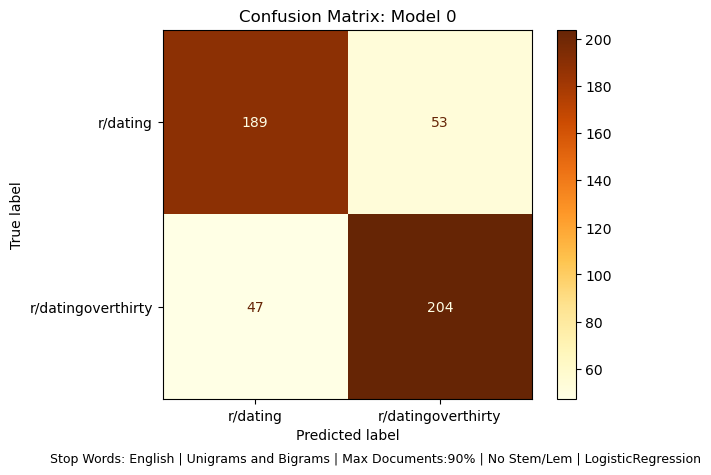

In [43]:
plt.figure(figsize = (8,5))
ConfusionMatrixDisplay.from_predictions(y_test, preds0, cmap = 'YlOrBr', display_labels=['r/dating','r/datingoverthirty'])
plt.title("Confusion Matrix: Model 0")
plt.suptitle('Stop Words: English | Unigrams and Bigrams | Max Documents:90% | No Stem/Lem | LogisticRegression', y=0, fontsize = 9)
plt.savefig(fname= './images/Model0_Confusion Matrix.png', bbox_inches = 'tight', dpi = 200);

## RS1
RandomSearchCV over Multiple Model Types with CountVectorization - Iteration

In [ ]:
pipe1 = Pipeline([
    ('cvec' , CountVectorizer()),
    ('cls' , Multi_Classifier())
])

params1 = [{ # list of params... one for each estimator (order matters here). Cite: Tim Office Hours
## Logistic Regression
         'cvec__max_df': [1.0, 0.9],
         # 'cvec__max_features': None,
         # 'cvec__min_df': 1,
         'cvec__ngram_range': [(1, 1), (1,2)],
         'cvec__preprocessor': [None, stem_post, lemmatize_post],
         'cvec__stop_words': [None, 'english'],
        
        'cls__estimator': [LogisticRegression()],
        'cls__estimator__C': np.linspace(0.00001, 1, 10),
        # 'cls__estimator__max_iter': 100,
        # 'cls__estimator__penalty': 'l2'
},
## Multinomial Naive Bayes
{        'cvec__max_df': [1.0, 0.9],
         # 'cvec__max_features': None,
         # 'cvec__min_df': 1,
         'cvec__ngram_range': [(1, 1), (1,2)],
         'cvec__preprocessor': [None, stem_post, lemmatize_post],
         'cvec__stop_words': [None, 'english'],
         
         'cls__estimator': [MultinomialNB()]
}]
# pipe0.get_params() ## For LogisticRegression
# pipe0.get_params() ## for Multinomial Naive Bayes

In [ ]:
rs1 = RandomizedSearchCV(estimator=pipe1,
                        param_distributions=params1,
                        cv = 5,
                        n_iter = 50
                       )

In [ ]:
%time
rs1.fit(X_train, y_train)

## VC 2
VotingClassifier Ensemble of KNN Classification with Tfidf Vectorization
> Using TFIDF Output, will an Bootstrap Aggregated Ensemble of K-Nearest Neighbors result in predictable performance?

In [26]:
pipe2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])
# pipe2.get_params()

In [27]:
params2 = {
     # 'tvec': TfidfVectorizer(),
     # 'knn': KNeighborsClassifier(),
     'tvec__max_df': np.linspace(0.8,1,5),
     # 'tvec__max_features': None,
     'tvec__min_df': np.linspace(0.01, 0.05, 3),
     'tvec__ngram_range': [(1, 1),(1,2),(1,3)],
     'tvec__preprocessor': [stem_post, lemmatize_post],
     'tvec__stop_words': [None, 'english'],
     'knn__n_neighbors': [5],
} #100 knn runs

In [28]:
vc2 = VotingClassifier(pipe2)

In [29]:
%%time
vc2.fit(X_train, y_train)

InvalidParameterError: The 'estimators' parameter of VotingClassifier must be an instance of 'list'. Got Pipeline(steps=[('tvec', TfidfVectorizer()), ('knn', KNeighborsClassifier())]) instead.

In [30]:
rs2 = RandomizedSearchCV(estimator=pipe2, 
                         param_distributions=params2,
                         cv = 5, 
                         # n_jobs=2,# n_jobs can call pickle when preparing models to run in parallel
                        n_iter=20) # 180 total combinations.  5 fold cross-validation.  running 20 tests

In [31]:
%%time
rs2.fit(X_train, y_train)

/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(
/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(
/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(
/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words g

CPU times: user 22min 13s, sys: 12.6 s, total: 22min 25s
Wall time: 31min 3s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                             ('knn', KNeighborsClassifier())]),
                   n_iter=20,
                   param_distributions={'knn__n_neighbors': [5],
                                        'tvec__max_df': array([0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                                        'tvec__min_df': array([0.01, 0.03, 0.05]),
                                        'tvec__ngram_range': [(1, 1), (1, 2),
                                                              (1, 3)],
                                        'tvec__preprocessor': [<function stem_post at 0x7fbf4dfebb50>,
                                                               <function lemmatize_post at 0x7fbf48805510>],
                                        'tvec__stop_words': [None, 'english']})

In [42]:
rs2.best_params_

{'tvec__stop_words': None,
 'tvec__preprocessor': <function __main__.lemmatize_post(post)>,
 'tvec__ngram_range': (1, 1),
 'tvec__min_df': 0.02,
 'tvec__max_df': 0.6842105263157895,
 'knn__n_neighbors': 5}